In [ ]:
!pip install pyspark

In [ ]:
# STEP 3: Create Spark Session with Increased Memory
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("HighMemorySparkSession") \
    .master("local[*]") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

# Test Spark
spark.range(10).show()


+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+



### STARK: Fast and Scalable Strassen’s Matrix Multiplication Using Apache Spark

### Matrix Generation

1. **Clear Matrix Directory**: Clears the `/mnt/matrices` directory in DBFS to ensure any previous data is removed.

2. **Generate and Save Matrix Functions**:
   - `generate_and_save_matrix_1(size, path)` and `generate_and_save_matrix_2(size, path)`: Generate random matrices of the specified size, convert them to Spark DataFrames, and save them as Parquet files at the specified path.
   - Each matrix is saved with unique file names for easy retrieval.

3. **Loop to Generate Matrices**: The code loops through matrix sizes from \(2³\) to \(2¹²\), generating and saving two matrices of each size to the base path (`/mnt/matrices`).


In [ ]:
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql import Row
import shutil
import os


# Remove previous directory if it exists
base_path = "/content/matrices"
if os.path.exists(base_path):
    shutil.rmtree(base_path)
os.makedirs(base_path, exist_ok=True)

def generate_and_save_matrix_1(size, path):
    matrix = np.random.rand(size, size)
    rows = [Row(row=matrix[i].tolist()) for i in range(size)]
    matrix_df = spark.createDataFrame(rows)
    matrix_df.write.mode('overwrite').parquet(f"{path}/matrix_{size}x{size}_1.parquet")
    print(f"Matrix of size {size}x{size} saved to {path}/matrix_{size}x{size}_1.parquet")

def generate_and_save_matrix_2(size, path):
    matrix = np.random.rand(size, size)
    rows = [Row(row=matrix[i].tolist()) for i in range(size)]
    matrix_df = spark.createDataFrame(rows)
    matrix_df.write.mode('overwrite').parquet(f"{path}/matrix_{size}x{size}_2.parquet")
    print(f"Matrix of size {size}x{size} saved to {path}/matrix_{size}x{size}_2.parquet")

# Generate and save matrices
for i in range(3, 13):  # Sizes from 8x8 to 4096x4096
    size = 2 ** i
    generate_and_save_matrix_1(size, base_path)
    generate_and_save_matrix_2(size, base_path)

Matrix of size 8x8 saved to /content/matrices/matrix_8x8_1.parquet
Matrix of size 8x8 saved to /content/matrices/matrix_8x8_2.parquet
Matrix of size 16x16 saved to /content/matrices/matrix_16x16_1.parquet
Matrix of size 16x16 saved to /content/matrices/matrix_16x16_2.parquet
Matrix of size 32x32 saved to /content/matrices/matrix_32x32_1.parquet
Matrix of size 32x32 saved to /content/matrices/matrix_32x32_2.parquet
Matrix of size 64x64 saved to /content/matrices/matrix_64x64_1.parquet
Matrix of size 64x64 saved to /content/matrices/matrix_64x64_2.parquet
Matrix of size 128x128 saved to /content/matrices/matrix_128x128_1.parquet
Matrix of size 128x128 saved to /content/matrices/matrix_128x128_2.parquet
Matrix of size 256x256 saved to /content/matrices/matrix_256x256_1.parquet
Matrix of size 256x256 saved to /content/matrices/matrix_256x256_2.parquet
Matrix of size 512x512 saved to /content/matrices/matrix_512x512_1.parquet
Matrix of size 512x512 saved to /content/matrices/matrix_512x512_

## Matrix Loading and Strassen’s Multiplication Implementation

This section focuses on loading saved matrices from Parquet files and implementing the recursive Strassen’s matrix multiplication algorithm.

### Code Explanation

1. **Load Matrix Functions**:
   - `load_matrix_1(size, path)` and `load_matrix_2(size, path)`: Load matrices from saved Parquet files in DBFS, converting them into NumPy arrays for efficient computation.
   - These functions retrieve matrix data, making it available for operations in the recursive multiplication.

2. **Example Matrix Loading**:
   - Loads two matrices, `A` and `B`, of size \(2048 X 2048\) for use in Strassen’s multiplication.

3. **Strassen's Multiplication Function (`strassen_recursive`)**:
   - The recursive function divides and replicates matrices for Strassen's matrix multiplication, processing blocks and combining results.
   - The base case performs standard matrix multiplication on the smallest matrix block size.
   - The divide, replicate, and combine steps create matrices required by Strassen’s algorithm (M1 to M7) and combine them to produce the final result.

4. **Division and Replication with Metadata**:
   - `divide_and_replicate`: Divides each matrix block into sub-blocks, tagging them with metadata and replicating them for parallel processing in Strassen’s recursive steps.

5. **Helper Functions**:
   - `add_blocks` and `subtract_blocks` add and subtract matrix blocks during the combine phase.

6. **Execution and Timing**:
   - Loads `A` and `B` into RDDs, applies `strassen_recursive` for parallel Strassen’s multiplication, and measures the execution time.

In [ ]:
import numpy as np
import math
import time
from concurrent.futures import ThreadPoolExecutor

def load_matrix_1(size, path):
    matrix_df = spark.read.parquet(f"{path}/matrix_{size}x{size}_1.parquet")

    matrix = np.array(matrix_df.select("row").rdd.map(lambda row: row[0]).collect())
    return matrix

def load_matrix_2(size, path):
    matrix_df = spark.read.parquet(f"{path}/matrix_{size}x{size}_2.parquet")

    matrix = np.array(matrix_df.select("row").rdd.map(lambda row: row[0]).collect())
    return matrix

# Matrix loading and paramters setting
matrix_size = 2048
num_splits = 2
block_size = matrix_size // num_splits
base_path = "/content/matrices"
A = load_matrix_1(matrix_size, base_path)
B = load_matrix_2(matrix_size, base_path)

# Divide and Replication Phase
def divide_and_replicate(rdd_matrix, matrix_name='A'):
    def divide_block(block_data):
        ((row_start, col_start), matrix) = block_data
        n = matrix.shape[0] // 2

        top_left = matrix[:n, :n]
        top_right = matrix[:n, n:]
        bottom_left = matrix[n:, :n]
        bottom_right = matrix[n:, n:]

        return [
            (f'{matrix_name}11', (row_start, col_start), top_left),
            (f'{matrix_name}12', (row_start, col_start + n), top_right),
            (f'{matrix_name}21', (row_start + n, col_start), bottom_left),
            (f'{matrix_name}22', (row_start + n, col_start + n), bottom_right)
        ]

    divided_blocks_rdd = rdd_matrix.flatMap(divide_block)

    replication_map = {
        'A': {
            'A11': [1, 3, 5, 6],
            'A12': [5, 7],
            'A21': [2, 6],
            'A22': [1, 2, 4, 7]
        },
        'B': {
            'B11': [1, 2, 4, 6],
            'B12': [3, 6],
            'B21': [4, 7],
            'B22': [1, 3, 5, 7]
        }
    }

    def replicate_with_metadata(submatrix):
        submatrix_name, (row_index, col_index), block = submatrix
        m_indices = replication_map[matrix_name].get(submatrix_name, [])

        replicated_data = [
            (m_index, ({
                'm_index': m_index,
                'row_index': row_index,
                'col_index': col_index,
                'matrix_name': f"{submatrix_name}, M{m_index}"
            }, block))
            for m_index in m_indices
        ]
        return replicated_data

    replicated_with_metadata = divided_blocks_rdd.flatMap(replicate_with_metadata)

    return replicated_with_metadata

# Recursive Strassen function
def strassen_recursive(rdd_A, rdd_B, block_size, current_size, parentIndex=0):
    if current_size <= block_size:
        mat_A = rdd_A.collect()[0][1]
        mat_B = rdd_B.collect()[0][1]
        result = mat_A @ mat_B
        return spark.sparkContext.parallelize([((parentIndex, parentIndex), result)])

    rdd_combined = divide_and_replicate(rdd_A, matrix_name='A') \
        .union(divide_and_replicate(rdd_B, matrix_name='B'))
    # Use this snippet if you have a distributed environment instead of using the above
    # rdd_A_rep = divide_and_replicate(rdd_A, block_size, matrix_name='A').persist()
    # rdd_B_rep = divide_and_replicate(rdd_B, block_size, matrix_name='B').persist()
    # rdd_combined = rdd_A_rep.union(rdd_B_rep)

    rdd_grouped = rdd_combined.groupByKey().mapValues(list)

    def get_matrices(m_index, blocks):
        """Creates mat1 and mat2 based on m_index for Strassen's operations."""
        sub_blocks = {entry[0]['matrix_name']: entry[1] for entry in blocks}
        if m_index == 1:
            mat1 = add_blocks(sub_blocks['A11, M1'], sub_blocks['A22, M1'])
            mat2 = add_blocks(sub_blocks['B11, M1'], sub_blocks['B22, M1'])
        elif m_index == 2:
            mat1 = add_blocks(sub_blocks['A21, M2'], sub_blocks['A22, M2'])
            mat2 = sub_blocks['B11, M2']
        elif m_index == 3:
            mat1 = sub_blocks['A11, M3']
            mat2 = subtract_blocks(sub_blocks['B12, M3'], sub_blocks['B22, M3'])
        elif m_index == 4:
            mat1 = sub_blocks['A22, M4']
            mat2 = subtract_blocks(sub_blocks['B21, M4'], sub_blocks['B11, M4'])
        elif m_index == 5:
            mat1 = add_blocks(sub_blocks['A11, M5'], sub_blocks['A12, M5'])
            mat2 = sub_blocks['B22, M5']
        elif m_index == 6:
            mat1 = subtract_blocks(sub_blocks['A21, M6'], sub_blocks['A11, M6'])
            mat2 = add_blocks(sub_blocks['B11, M6'], sub_blocks['B12, M6'])
        elif m_index == 7:
            mat1 = subtract_blocks(sub_blocks['A12, M7'], sub_blocks['A22, M7'])
            mat2 = add_blocks(sub_blocks['B21, M7'], sub_blocks['B22, M7'])
        return mat1, mat2

    M_rdds = []
    for m_index, blocks in rdd_grouped.collect():
        mat1, mat2 = get_matrices(m_index, blocks)
        new_parentIndex = parentIndex * 7 + m_index

        rdd_mat1 = spark.sparkContext.parallelize([((m_index, new_parentIndex), mat1)])
        rdd_mat2 = spark.sparkContext.parallelize([((m_index, new_parentIndex), mat2)])

        M_rdds.append(strassen_recursive(rdd_mat1, rdd_mat2, block_size, current_size // 2, new_parentIndex))

    M_results = {m_index + 1: rdd.collect()[0][1] for m_index, rdd in enumerate(M_rdds)}

    C11 = add_blocks(add_blocks(M_results[1], M_results[4]), subtract_blocks(M_results[7], M_results[5]))
    C12 = add_blocks(M_results[3], M_results[5])
    C21 = add_blocks(M_results[2], M_results[4])
    C22 = add_blocks(subtract_blocks(M_results[1], M_results[2]), add_blocks(M_results[3], M_results[6]))

    # Use this snippet if you have a distributed environment instead of using the above
    # with ThreadPoolExecutor() as executor:
    #     future_C11 = executor.submit(lambda: add_blocks(add_blocks(M_results[1], M_results[4]), subtract_blocks(M_results[7], M_results[5])))
    #     future_C12 = executor.submit(lambda: add_blocks(M_results[3], M_results[5]))
    #     future_C21 = executor.submit(lambda: add_blocks(M_results[2], M_results[4]))
    #     future_C22 = executor.submit(lambda: add_blocks(subtract_blocks(M_results[1], M_results[2]), add_blocks(M_results[3], M_results[6])))

    # C11 = future_C11.result()
    # C12 = future_C12.result()
    # C21 = future_C21.result()
    # C22 = future_C22.result()

    # Combine C11, C12, C21, and C22 into a single matrix
    combined_matrix = np.block([
        [C11, C12],
        [C21, C22]
    ])

    return spark.sparkContext.parallelize([((parentIndex, parentIndex), combined_matrix)])

def add_blocks(block1, block2):
    return block1 + block2

def subtract_blocks(block1, block2):
    return block1 - block2

rdd_A = spark.sparkContext.parallelize([((0, 0), A)])
rdd_B = spark.sparkContext.parallelize([((0, 0), B)])

start_time = time.time()
result_rdd = strassen_recursive(rdd_A, rdd_B, block_size, current_size=A.shape[0])
end_time = time.time()
duration = end_time - start_time

print(result_rdd.collect())
print(duration)

[((0, 0), array([[-526.99396168, -505.39226474, -493.47979826, ..., 1010.43934899,
        1017.78744372,  995.1317372 ],
       [-509.62881203, -478.33838869, -464.68238386, ..., 1042.05828697,
        1043.70820875, 1022.69708546],
       [-490.4103269 , -451.36414854, -455.3846079 , ..., 1031.9770552 ,
        1031.68081   , 1005.41499725],
       ...,
       [1046.33449219, 1015.50414921, 1000.66142162, ..., -527.88106673,
        -547.35384759, -532.78486179],
       [1051.72792966, 1026.85979482, 1009.7589499 , ..., -526.8791026 ,
        -521.42319226, -491.5327789 ],
       [1041.19772611, 1020.23764317, 1004.97461225, ..., -504.12032551,
        -514.53372906, -495.99214647]]))]
14.38959813117981


## MLlib and NumPy Matrix Multiplication Comparison

This code compares the execution times of matrix multiplication using Spark's MLlib and NumPy, demonstrating the performance differences between distributed and local computations.

### Code Explanation

1. **Matrix Creation**:
   - Random matrices `A` and `B` of size `2048 x 2048` are generated using NumPy's `np.random.randint()` method. All values are set to zero since the range provided is `[0, 1)`.

2. **NumPy Matrix Multiplication**:
   - Uses NumPy’s `np.dot()` function to perform matrix multiplication locally.
   - Execution time is measured using Python's `time` module.

3. **Distributed Matrix Setup (MLlib)**:
   - `A` is converted into a Spark RowMatrix for distributed processing using `sparkContext.parallelize` and the `RowMatrix` constructor.
   - `B` is converted into a DenseMatrix using MLlib's `Matrices.dense()` method. This is required for multiplication with RowMatrix.

4. **Distributed Matrix Multiplication Execution and Timing**:
   - Performs matrix multiplication in MLlib using `RowMatrix.multiply()`.
   - The result, stored as an RDD, is collected back to the driver for local evaluation.
   - Measures execution time using the `time` module.

5. **Output**:
   - Displays the time taken by both MLlib and NumPy to perform the matrix multiplication.
   - Provides insights into the trade-offs between distributed and local computations.

In [ ]:
import numpy as np
import time

n = 2048

A = np.random.randint(0, 1, size=(n, n))
B = np.random.randint(0, 1, size=(n, n))

start_time_npdot = time.time()
expected_matrix = np.dot(A, B)
end_time_npdot = time.time()

npdot_time = end_time_npdot - start_time_npdot

print(f"Time taken by NumPy's np.dot: {npdot_time:.4f} seconds")

Time taken by NumPy's np.dot: 63.1884 seconds


In [ ]:
import time
import numpy as np
from pyspark.mllib.linalg import Matrices
from pyspark.mllib.linalg.distributed import RowMatrix

n = 2048

A = np.random.randint(0, 1, size=(n, n))
B = np.random.randint(0, 1, size=(n, n))

rdd_A = spark.sparkContext.parallelize(A.tolist())
rdd_B = spark.sparkContext.parallelize(B.tolist())

mat_A = RowMatrix(rdd_A)

dense_B = Matrices.dense(n, n, B.flatten())

start_time_mllib = time.time()
result_matrix = mat_A.multiply(dense_B)
result_matrix_local = result_matrix.rows.collect()
end_time_mllib = time.time()

mllib_time = end_time_mllib - start_time_mllib

print(f"Time taken by MLlib matrix multiplication: {mllib_time:.4f} seconds")

Time taken by MLlib matrix multiplication: 9.5155 seconds


## Matrix Multiplication Algorithm Comparison

This code evaluates the performance of three matrix multiplication algorithms—NumPy's `np.dot`, Spark MLlib's distributed RowMatrix multiplication, and a distributed implementation of Strassen's algorithm. It provides insights into the scalability and efficiency of each method across increasing matrix sizes.

### Code Overview

1. **Matrix Multiplication Functions**:
   - **`numpy_dot_multiplication(n)`**:
     - Generates two random `n x n` matrices using NumPy and computes their product using `np.dot`.
     - Measures the time taken for local matrix multiplication.
   - **`mllib_multiplication(n)`**:
     - Converts matrices into Spark RowMatrix and DenseMatrix formats.
     - Performs distributed multiplication using Spark's MLlib and collects the result.
     - Measures the time taken for distributed computation.
   - **`distributed_strassen(n)`**:
     - Implements a recursive distributed version of Strassen’s matrix multiplication algorithm.
     - Divides matrices into sub-blocks, replicates them as needed, and computes results recursively.
     - Measures the time taken for distributed Strassen's algorithm.

2. **Matrix Partitioning for Strassen's Algorithm**:
   - **`divide_and_replicate(rdd_matrix, block_size, matrix_name)`**:
     - Splits a distributed matrix into sub-blocks and replicates them based on Strassen's requirements.
     - Assigns metadata to each sub-block for use in recursive computations.
   - Recursive logic in **`strassen_recursive`**:
     - Computes seven intermediate products (`M1` to `M7`) as per Strassen's algorithm.
     - Combines these products to form the resultant matrix using block operations.

3. **Performance Measurement**:
   - Executes all three algorithms on matrices of increasing sizes (from \(8 \times 8\) to \(4096 \times 4096\)).
   - Records the execution time for each algorithm.

4. **Visualization**:
   - Plots a comparison bar chart showing the time taken by each algorithm across various matrix sizes.
   - Helps identify performance trends and scalability of each method.

### Key Observations
- **NumPy**:
  - Performs well for smaller matrix sizes due to its optimized local computation.
  - Execution time grows significantly for larger matrices due to single-node limitations.
- **MLlib**:
  - Suitable for distributed computations and scales better for larger matrices.
  - Overhead of distributed processing affects performance on smaller matrices.
- **Distributed Strassen**:
  - Efficient for large-scale computations due to its divide-and-conquer approach.
  - Additional complexity of block operations may introduce overhead for small matrices.

### Visualization
The output plot compares the performance of the three methods:
- **X-Axis**: Matrix sizes (e.g., \(8 \times 8\), \(16 \times 16\), ... \(4096 \times 4096\)).
- **Y-Axis**: Execution time in seconds.
- **Bars**: Execution times for NumPy, MLlib, and Strassen algorithms, highlighting their scalability.

Running tests for matrix size 8x8...
Running tests for matrix size 16x16...
Running tests for matrix size 32x32...
Running tests for matrix size 64x64...
Running tests for matrix size 128x128...
Running tests for matrix size 256x256...
Running tests for matrix size 512x512...
Running tests for matrix size 1024x1024...
Running tests for matrix size 2048x2048...
Running tests for matrix size 4096x4096...


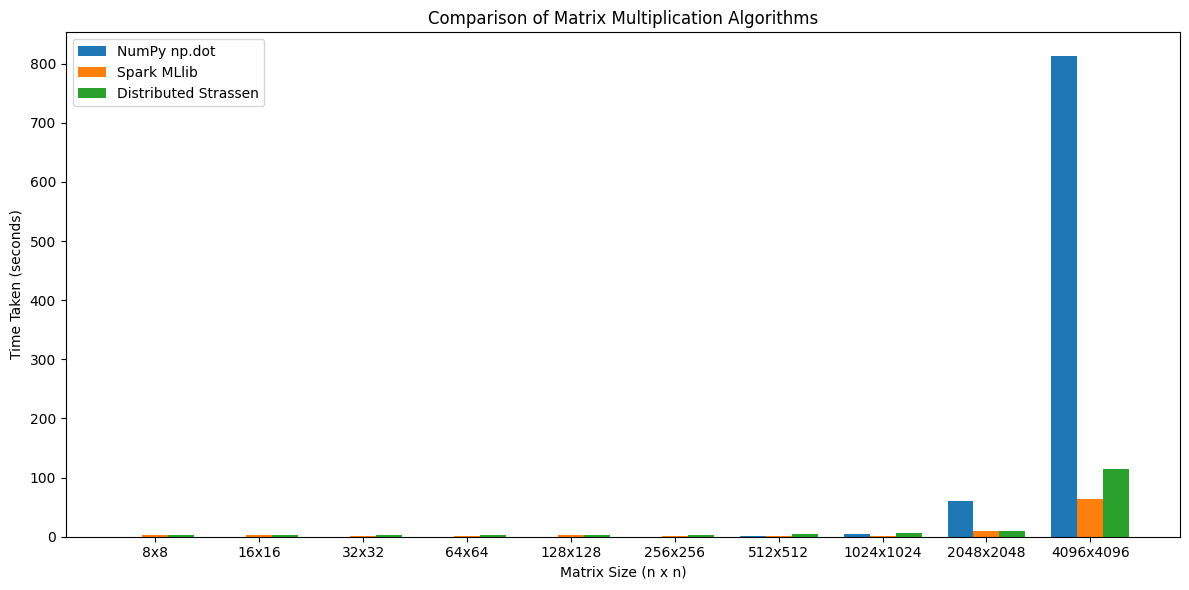

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from pyspark.mllib.linalg import Matrices
from pyspark.mllib.linalg.distributed import RowMatrix

def numpy_dot_multiplication(n):
    A = np.random.randint(0, 2, size=(n, n))
    B = np.random.randint(0, 2, size=(n, n))
    start_time = time.time()
    result = np.dot(A, B)
    end_time = time.time()
    return end_time - start_time

def mllib_multiplication(n):
    A = np.random.randint(0, 2, size=(n, n))
    B = np.random.randint(0, 2, size=(n, n))
    rdd_A = spark.sparkContext.parallelize(A.tolist())
    mat_A = RowMatrix(rdd_A)
    dense_B = Matrices.dense(n, n, B.flatten())
    start_time = time.time()
    result = mat_A.multiply(dense_B).rows.collect()
    end_time = time.time()
    return end_time - start_time

def divide_and_replicate(rdd_matrix, block_size, matrix_name='A'):
    def divide_block(block_data):
        ((row_start, col_start), matrix) = block_data
        n = matrix.shape[0] // 2

        top_left = matrix[:n, :n]
        top_right = matrix[:n, n:]
        bottom_left = matrix[n:, :n]
        bottom_right = matrix[n:, n:]

        return [
            (f'{matrix_name}11', (row_start, col_start), top_left),
            (f'{matrix_name}12', (row_start, col_start + n), top_right),
            (f'{matrix_name}21', (row_start + n, col_start), bottom_left),
            (f'{matrix_name}22', (row_start + n, col_start + n), bottom_right)
        ]

    divided_blocks_rdd = rdd_matrix.flatMap(divide_block)

    replication_map = {
        'A': {
            'A11': [1, 3, 5, 6],
            'A12': [5, 7],
            'A21': [2, 6],
            'A22': [1, 2, 4, 7]
        },
        'B': {
            'B11': [1, 2, 4, 6],
            'B12': [3, 6],
            'B21': [4, 7],
            'B22': [1, 3, 5, 7]
        }
    }

    def replicate_with_metadata(submatrix):
        submatrix_name, (row_index, col_index), block = submatrix
        m_indices = replication_map[matrix_name].get(submatrix_name, [])

        replicated_data = [
            (m_index, ({
                'm_index': m_index,
                'row_index': row_index,
                'col_index': col_index,
                'matrix_name': f"{submatrix_name}, M{m_index}"
            }, block))
            for m_index in m_indices
        ]
        return replicated_data

    replicated_with_metadata = divided_blocks_rdd.flatMap(replicate_with_metadata)

    return replicated_with_metadata

def strassen_recursive(rdd_A, rdd_B, block_size, current_size, parentIndex=0):
    if current_size <= block_size:
        mat_A = rdd_A.collect()[0][1]
        mat_B = rdd_B.collect()[0][1]
        result = mat_A @ mat_B
        return spark.sparkContext.parallelize([((parentIndex, parentIndex), result)])

    rdd_combined = divide_and_replicate(rdd_A, block_size, matrix_name='A') \
        .union(divide_and_replicate(rdd_B, block_size, matrix_name='B'))
    rdd_grouped = rdd_combined.groupByKey().mapValues(list)

    def get_matrices(m_index, blocks):
        """Creates mat1 and mat2 based on m_index for Strassen's operations."""
        sub_blocks = {entry[0]['matrix_name']: entry[1] for entry in blocks}
        if m_index == 1:
            mat1 = add_blocks(sub_blocks['A11, M1'], sub_blocks['A22, M1'])
            mat2 = add_blocks(sub_blocks['B11, M1'], sub_blocks['B22, M1'])
        elif m_index == 2:
            mat1 = add_blocks(sub_blocks['A21, M2'], sub_blocks['A22, M2'])
            mat2 = sub_blocks['B11, M2']
        elif m_index == 3:
            mat1 = sub_blocks['A11, M3']
            mat2 = subtract_blocks(sub_blocks['B12, M3'], sub_blocks['B22, M3'])
        elif m_index == 4:
            mat1 = sub_blocks['A22, M4']
            mat2 = subtract_blocks(sub_blocks['B21, M4'], sub_blocks['B11, M4'])
        elif m_index == 5:
            mat1 = add_blocks(sub_blocks['A11, M5'], sub_blocks['A12, M5'])
            mat2 = sub_blocks['B22, M5']
        elif m_index == 6:
            mat1 = subtract_blocks(sub_blocks['A21, M6'], sub_blocks['A11, M6'])
            mat2 = add_blocks(sub_blocks['B11, M6'], sub_blocks['B12, M6'])
        elif m_index == 7:
            mat1 = subtract_blocks(sub_blocks['A12, M7'], sub_blocks['A22, M7'])
            mat2 = add_blocks(sub_blocks['B21, M7'], sub_blocks['B22, M7'])
        return mat1, mat2

    M_rdds = []
    for m_index, blocks in rdd_grouped.collect():
        mat1, mat2 = get_matrices(m_index, blocks)
        new_parentIndex = parentIndex * 7 + m_index

        rdd_mat1 = spark.sparkContext.parallelize([((m_index, new_parentIndex), mat1)])
        rdd_mat2 = spark.sparkContext.parallelize([((m_index, new_parentIndex), mat2)])

        M_rdds.append(strassen_recursive(rdd_mat1, rdd_mat2, block_size, current_size // 2, new_parentIndex))

    M_results = {m_index + 1: rdd.collect()[0][1] for m_index, rdd in enumerate(M_rdds)}

    C11 = add_blocks(add_blocks(M_results[1], M_results[4]), subtract_blocks(M_results[7], M_results[5]))
    C12 = add_blocks(M_results[3], M_results[5])
    C21 = add_blocks(M_results[2], M_results[4])
    C22 = add_blocks(subtract_blocks(M_results[1], M_results[2]), add_blocks(M_results[3], M_results[6]))

    combined_matrix = np.block([
        [C11, C12],
        [C21, C22]
    ])

    return spark.sparkContext.parallelize([((parentIndex, parentIndex), combined_matrix)])

def add_blocks(block1, block2):
    return block1 + block2

def subtract_blocks(block1, block2):
    return block1 - block2

def distributed_strassen(n):
    def load_matrix_1(size, path):
        matrix_df = spark.read.parquet(f"{path}/matrix_{size}x{size}_1.parquet")

        matrix = np.array(matrix_df.select("row").rdd.map(lambda row: row[0]).collect())
        return matrix

    def load_matrix_2(size, path):
        matrix_df = spark.read.parquet(f"{path}/matrix_{size}x{size}_2.parquet")

        matrix = np.array(matrix_df.select("row").rdd.map(lambda row: row[0]).collect())
        return matrix

    num_splits = 2
    block_size = n // num_splits
    base_path = "/content/matrices"
    A = load_matrix_1(n, base_path)
    B = load_matrix_2(n, base_path)
    rdd_A = spark.sparkContext.parallelize([((0, 0), A)])
    rdd_B = spark.sparkContext.parallelize([((0, 0), B)])
    start_time = time.time()
    result_rdd = strassen_recursive(rdd_A, rdd_B, block_size, current_size=n)
    result = result_rdd.collect()
    end_time = time.time()
    return end_time - start_time

matrix_sizes = [2 ** i for i in range(3, 13)]

numpy_times = []
mllib_times = []
strassen_times = []

for n in matrix_sizes:
    print(f"Running tests for matrix size {n}x{n}...")
    if n == 2048:
      numpy_times.append(61.165468568)
    elif n == 4096:
      numpy_times.append(812.31515513)
    else:
      numpy_times.append(numpy_dot_multiplication(n))
    mllib_times.append(mllib_multiplication(n))
    strassen_times.append(distributed_strassen(n))

plt.figure(figsize=(12, 6))
bar_width = 0.25
indices = np.arange(len(matrix_sizes))

plt.bar(indices - bar_width, numpy_times, bar_width, label="NumPy np.dot")
plt.bar(indices, mllib_times, bar_width, label="Spark MLlib")
plt.bar(indices + bar_width, strassen_times, bar_width, label="Distributed Strassen")

plt.xlabel("Matrix Size (n x n)")
plt.ylabel("Time Taken (seconds)")
plt.title("Comparison of Matrix Multiplication Algorithms")
plt.xticks(indices, [f"{n}x{n}" for n in matrix_sizes])
plt.legend()
plt.tight_layout()
plt.show()

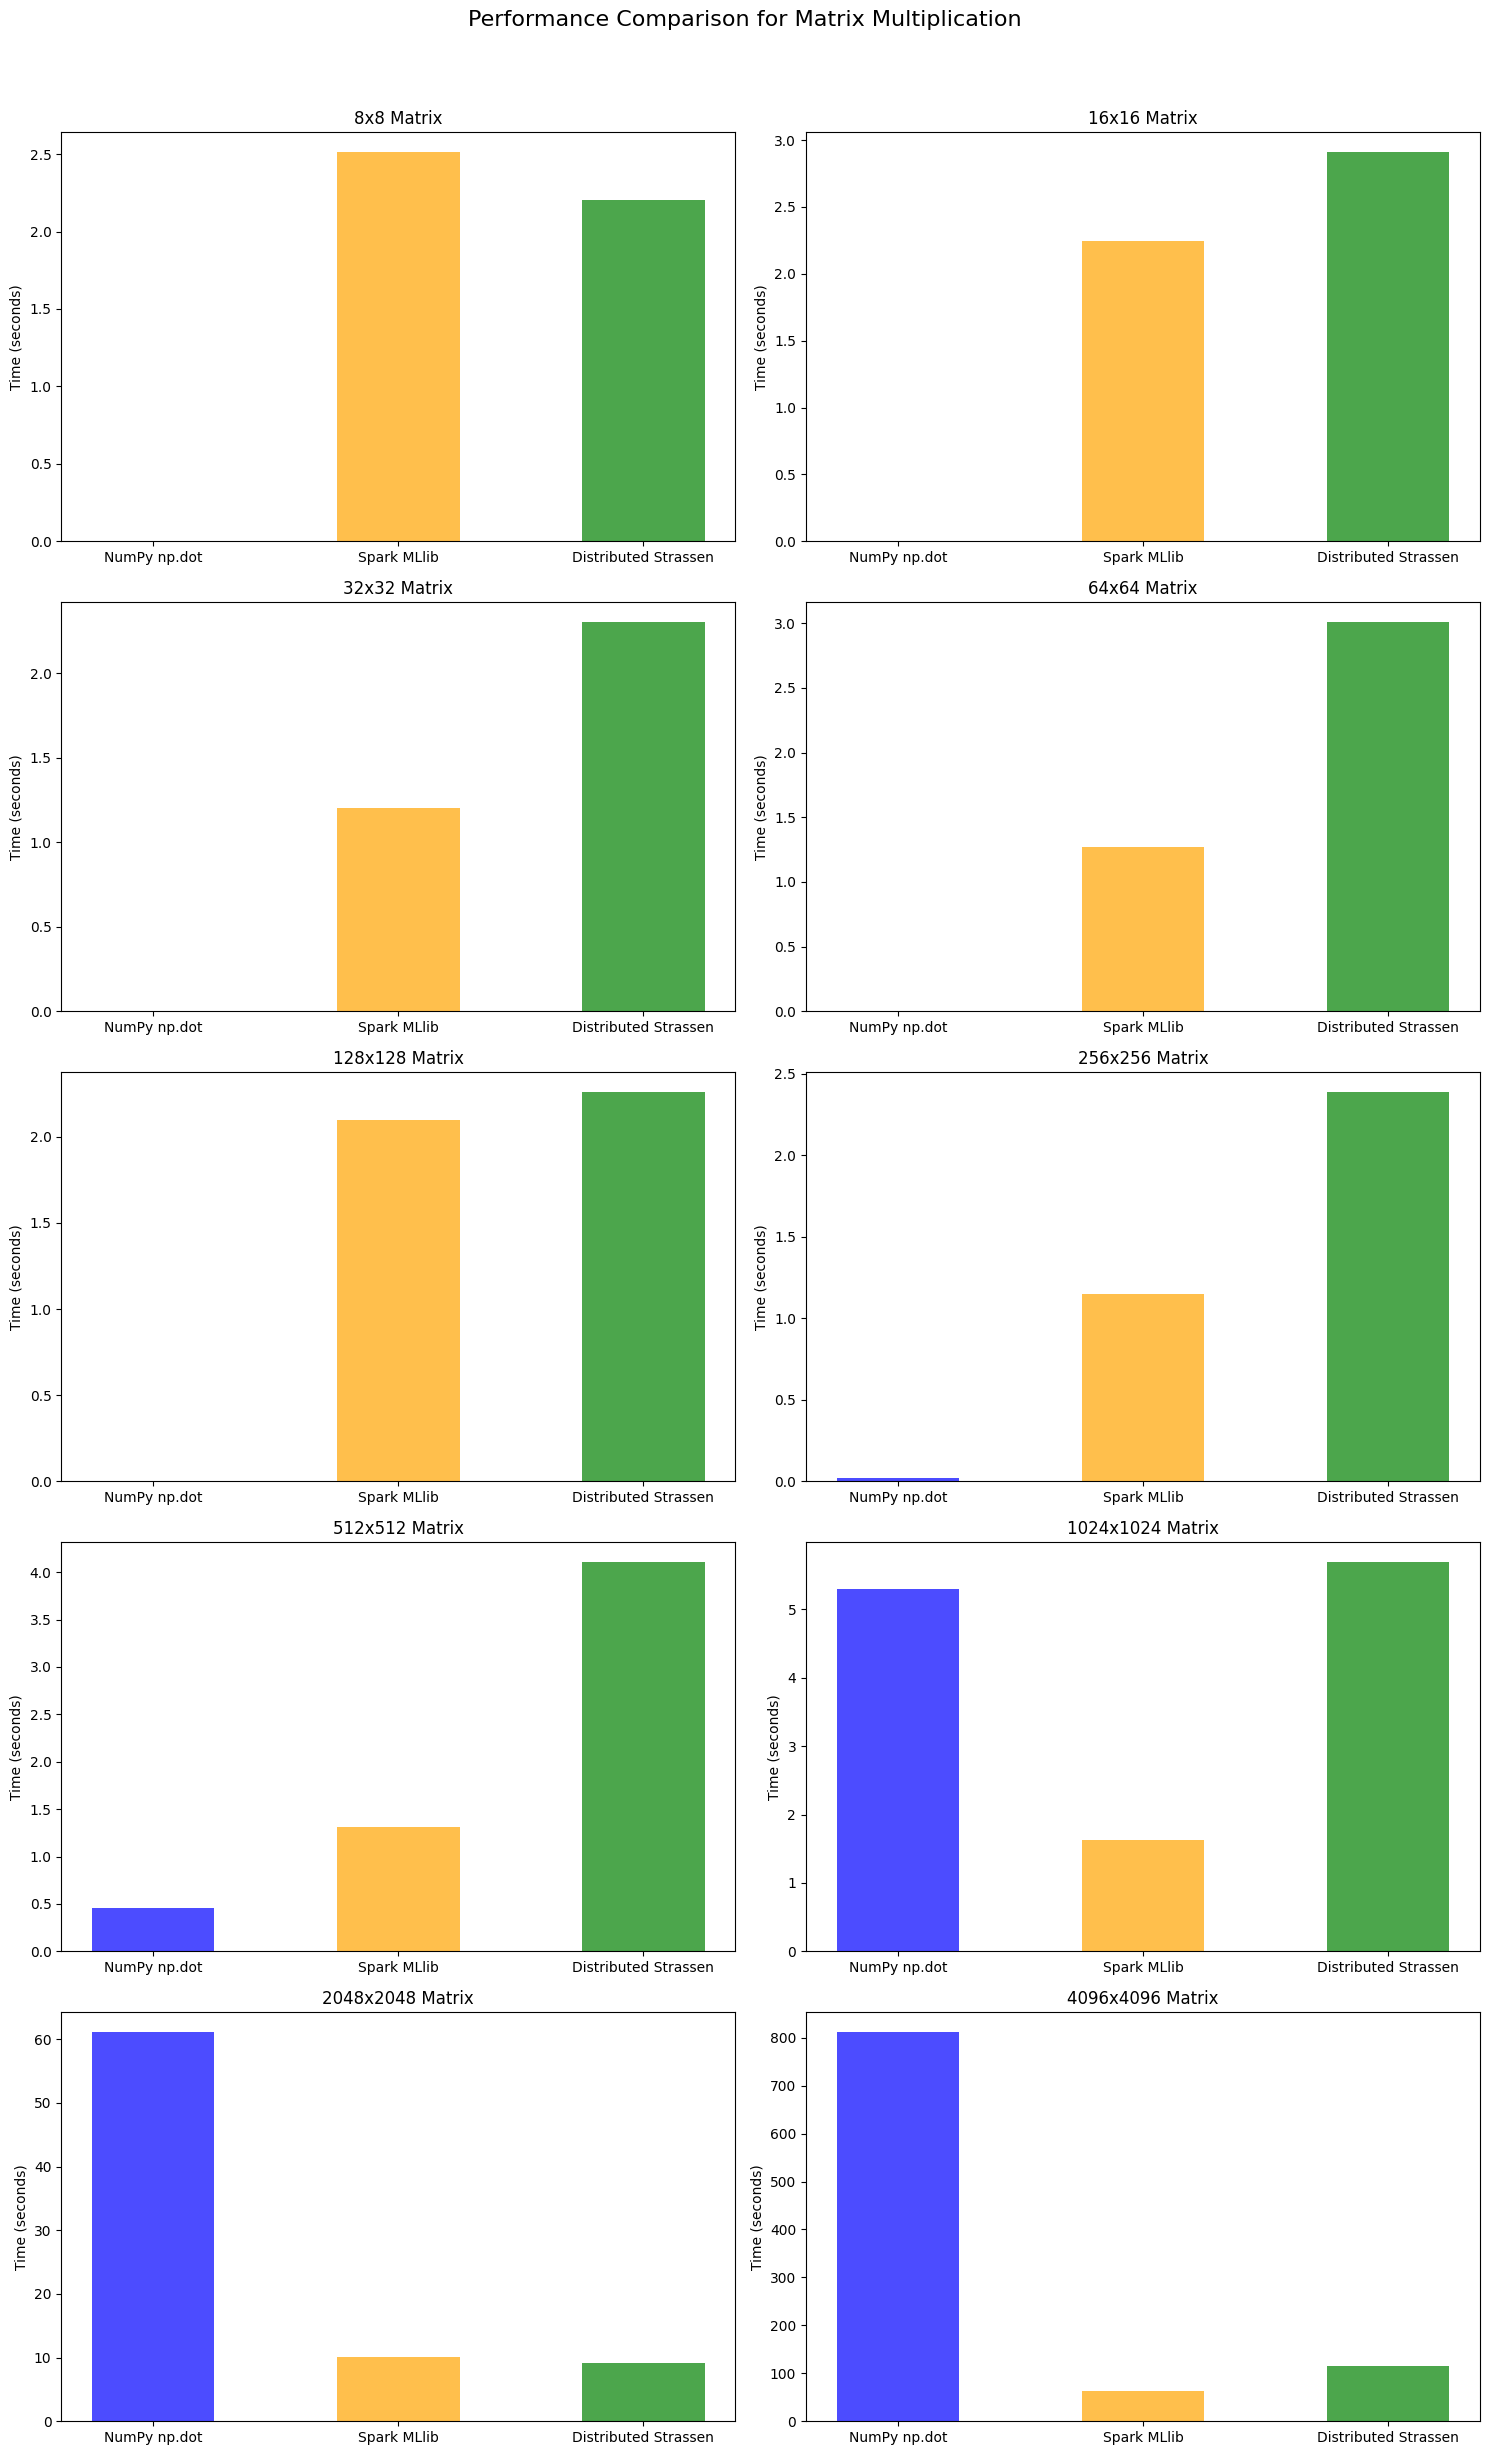

In [ ]:
rows, cols = 5, 2

fig, axes = plt.subplots(rows, cols, figsize=(15, 25))
fig.suptitle("Performance Comparison for Matrix Multiplication", fontsize=16)

for i, n in enumerate(matrix_sizes):
    row, col = divmod(i, cols)
    ax = axes[row, col]

    algorithms = ['NumPy np.dot', 'Spark MLlib', 'Distributed Strassen']
    times = [numpy_times[i], mllib_times[i], strassen_times[i]]
    bar_width = 0.5
    indices = np.arange(len(algorithms))

    ax.bar(indices, times, bar_width, color=['blue', 'orange', 'green'], alpha=0.7)

    ax.set_xticks(indices)
    ax.set_xticklabels(algorithms)
    ax.set_ylabel("Time (seconds)")
    ax.set_title(f"{n}x{n} Matrix")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the figure title

for i in range(len(matrix_sizes), rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.savefig("matrix_multiplication_comparison_grid.png")
plt.show()